<a href="https://colab.research.google.com/github/Paco-Danes/CondGanMap2Sat/blob/main/TryOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [13]:
# @title Small Generator Architecture

def conv_block(in_channels, out_channels): # out_c = feature_map
    # Performs convolution twice before downsampling with max pooling
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )   # Use padding to preserve the same image shape
    return conv_op

class Generator(nn.Module):
    def __init__(self, num_classes): # num_cla is the number of output channels = 3 for rgb images
        super(Generator, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoder conv layers.
        # Two convolutions each time using the predefined function.
        self.down_convolution_1 = conv_block(3, 64)
        self.down_convolution_2 = conv_block(64, 128)
        self.down_convolution_3 = conv_block(128, 256)
        self.down_convolution_4 = conv_block(256, 512)
        # Decoder layers for upsampling.
        # Transposed convolutions with stride 2 to up_sample the feature maps
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_1 = conv_block(512, 256) # 512 input channels due to the "skip connection" with concatenation
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = conv_block(256, 128) # Each conv. (Normal and transposed) decreases the number of channels
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = conv_block(128, 64)
        # Last layer for the output, creates 3 final channels with 1x1 conv.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        # Forward pass through the network
        # Initial shape = 128x128 (channels omitted)
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1) # 128 -> 64
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3) # 64 > 32
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5) # 32 -> 16
        down_7 = self.down_convolution_4(down_6)
        # Takes 16x16 image and upsamples it
        up_1 = self.up_transpose_1(down_7) # 16 -> 32
        x = self.up_convolution_1(torch.cat([down_5, up_1], 1)) # Skip connection of the U-net
        up_2 = self.up_transpose_2(x) # 32 -> 64
        x = self.up_convolution_2(torch.cat([down_3, up_2], 1)) # Skip connection of the U-net
        up_3 = self.up_transpose_3(x) # 64 -> 128
        x = self.up_convolution_3(torch.cat([down_1, up_3], 1)) # Skip connection of the U-net
        # Output conv. layer
        out = self.out(x) # 3 x 128 x 128
        return out

# Shape sanity check
inp = torch.rand((3,128,128)).unsqueeze(0)
m = Generator(3)
print(m.forward(inp).shape)
# Parameters count
sum(p.numel() for p in m.parameters() if p.requires_grad)

torch.Size([1, 3, 128, 128])


7697475

In [14]:
# @title BigGen architecture

def conv_block(in_channels, out_channels): # out_c = feature_map
    # Performs convolution twice before downsampling with max pooling
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )  # Use padding to preserve the same image shape
    return conv_op

class BigGen(nn.Module):
    def __init__(self, num_classes): # num_cla is the number of output channels = 3 for rgb images
        super(BigGen,self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoder conv layers.
        # Two convolutions each time using the predefined function.
        self.down_convolution_1 = conv_block(3, 64)
        self.down_convolution_2 = conv_block(64, 128)
        self.down_convolution_3 = conv_block(128, 256)
        self.down_convolution_4 = conv_block(256, 512)
        self.down_convolution_5 = conv_block(512, 1024) # Increased depth w.r.t. small gen
        # Decoder layers for upsampling.
        # Transposed convolutions with stride 2 to up_sample the feature maps
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        self.up_convolution_1 = conv_block(1024, 512) # 1024 input channels due to the "skip connection" with concatenation
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = conv_block(512, 256) # Each conv. (Normal and transposed) decreases the number of channels
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = conv_block(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = conv_block(128, 64)
        # Last layer for the output, creates 3 final channels with 1x1 conv.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        # Forward pass through the network
        # Initial shape = 128x128 (channels omitted)
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)          # 128 -> 64
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)          # 64 -> 32
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)          # 32 -> 16
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)          # 16 -> 8
        down_9 = self.down_convolution_5(down_8)
        # Takes 1024x8x8 image and upsamples it while decreasing channels down to 3
        up_1 = self.up_transpose_1(down_9) # 8 -> 16
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1)) # Skip connection of the U-net
        up_2 = self.up_transpose_2(x) # 16 -> 32
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1)) # Skip connection of the U-net
        up_3 = self.up_transpose_3(x) # 32 -> 64
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1)) # Skip connection of the U-net
        up_4 = self.up_transpose_4(x) # 64 -> 128
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1)) # Skip connection of the U-net
        # Last output conv. layer
        out = self.out(x) # 3 x 128 x 128
        return out


In [15]:
# @title Dataset Loader with optional augmentation
# This classs overwrites torch Dataset, so that all the images are loaded into ram when creating the dataset
# avoiding the bottleneck created by retrieval from hard-disk
class InMemoryCustomDataset(Dataset):
    def __init__(self, source_dir, target_dir, transform=None, augment_rotation=False):
        self.source_dir = source_dir
        self.target_dir = target_dir
        self.source_images = []  # This holds the OpenStreetMaps
        self.target_images = []  # This holds real Satellite views
        self.transform = transform
        self.augment_rotation = augment_rotation
        self.load_images_into_memory()

    def load_images_into_memory(self):
        source_files = sorted(os.listdir(self.source_dir))
        target_files = sorted(os.listdir(self.target_dir))

        for source_img_name, target_img_name in zip(source_files, target_files):
            source_img_path = os.path.join(self.source_dir, source_img_name)
            target_img_path = os.path.join(self.target_dir, target_img_name)
            try:
                source_img = cv2.imread(source_img_path)
                source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
                source_img = cv2.resize(source_img, (128, 128), cv2.INTER_AREA)  # Resize to 128x128

                target_img = cv2.imread(target_img_path)
                target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
                target_img = cv2.resize(target_img, (128, 128), cv2.INTER_AREA)  # Resize to 128x128

                self.source_images.append(source_img)
                self.target_images.append(target_img)

                if self.augment_rotation:
                    # Perform rotations and append to the dataset, decide how many rotations (scale at will)
                    for angle in [90, 180, 270]:
                        rotated_source = np.array(np.rot90(source_img, k=int(angle / 90))) # Perform rotation by k*90 degrees
                        rotated_target = np.array(np.rot90(target_img, k=int(angle / 90)))
                        self.source_images.append(rotated_source)
                        self.target_images.append(rotated_target)

            except Exception as e: # Just for debugging, some images might be currupted
                print(f"Error loading image (skipped) at path {source_img_path} or {target_img_path}: {e}")

    def __len__(self):
        return len(self.source_images)

    def __getitem__(self, idx):
        source_img = self.source_images[idx]
        target_img = self.target_images[idx]

        if self.transform:
            source_img = self.transform(source_img)
            target_img = self.transform(target_img)

        return {'source_image': source_img, 'target_image': target_img}


In [5]:
######## Insert your path to edinburgh test set
!unzip /content/drive/MyDrive/TestSetEdinburgh.zip> /dev/null

In [6]:
####### Insert your path to central belt test set
!unzip /content/drive/MyDrive/TestSetCentralBelt.zip> /dev/null

In [7]:
# Insert your path to the models checkpoints
EdiBigGen_PATH = "/content/drive/MyDrive/EdiBigGenBest.pth"
EdiRefDivergence_PATH = "/content/drive/MyDrive/Edi_RefDivergenceBest.pth"
CentralBeltBigGen_PATH = "/content/drive/MyDrive/CentralBeltBigGen.pth"
SmallGenCentralBelt_PATH = "/content/drive/MyDrive/SmallGenCentralBelt.pth"

In [16]:
#@title Load models and test set for evaluation.
# Load models trained on Edinburgh dataset
BigGenEdi = BigGen(num_classes=3).cuda()
DivGenEdi = BigGen(num_classes=3).cuda()
cp_BigGenEdi = torch.load(EdiBigGen_PATH)
cp_DivGenEdi = torch.load(EdiRefDivergence_PATH)
BigGenEdi.load_state_dict(cp_BigGenEdi['gen_state_dict'])
DivGenEdi.load_state_dict(cp_DivGenEdi['gen_state_dict'])

# Load models trained on CentralBelt (50'000) dataset
BigGenCent = BigGen(num_classes=3).cuda()
cp_BigGenCent = torch.load(CentralBeltBigGen_PATH)
BigGenCent.load_state_dict(cp_BigGenCent['gen_state_dict'])
SmallGenCent = Generator(num_classes=3).cuda()
cp_SmallGenCent = torch.load(SmallGenCentralBelt_PATH)
SmallGenCent.load_state_dict(cp_SmallGenCent['gen_state_dict'])

# Set the models to evaluation mode
BigGenEdi.eval()
DivGenEdi.eval()
BigGenCent.eval()

# Double gan: BigGen + refinement
divergenceNet = nn.Sequential(
    BigGenEdi,
    DivGenEdi
)

# Move the sequential model to GPU if available
divergenceNet = divergenceNet.cuda()

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Replace 'source_folder' and 'target_folder' with your actual folder paths
test_dataset_edi = InMemoryCustomDataset(source_dir='/content/tiles_edi1000/openstreetmap',
                                      target_dir='/content/tiles_edi1000/worldimagery-clarity',
                                      transform=transform,
                                      augment_rotation=False)

test_dataset_central = InMemoryCustomDataset(source_dir='/content/tiles_central-belt7500/openstreetmap',
                                      target_dir='/content/tiles_central-belt7500/worldimagery-clarity',
                                      transform=transform,
                                      augment_rotation=False)


print("Number of test images-edi: ", len(test_dataset_edi))
print("Number of test images-central: ", len(test_dataset_central))

Error loading image (skipped) at path /content/tiles_central-belt7500/openstreetmap/17_64330_40815.png or /content/tiles_central-belt7500/worldimagery-clarity/17_64330_40815.png: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Error loading image (skipped) at path /content/tiles_central-belt7500/openstreetmap/17_64331_40814.png or /content/tiles_central-belt7500/worldimagery-clarity/17_64331_40814.png: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Number of test images-edi:  910
Number of test images-central:  7414


In [17]:
# @title Test images Show-Off, comparison between 2 models
def showOff(first_m, second_m, data):
  # Get a batch of images from the test loader
  test_loader = DataLoader(data, batch_size=6, shuffle=True)
  data_iterator = iter(test_loader)
  images = next(data_iterator)

  # Extract source images
  source_images = images['source_image'].to('cuda')
  # Generate target imgs using source imgs with both models, BigGen and BigGen+Refinement
  with torch.no_grad():
      gen_no_ref = first_m(source_images)
      generated_targets = second_m(source_images)

  # Plot everything, rows: source; BigGen; BigGen + Refinement
  fig, axes = plt.subplots(3, 6, figsize=(12, 7))

  for i in range(6):
      source_img = source_images[i].cpu().permute(1, 2, 0)
      gen_img = gen_no_ref[i].cpu().permute(1, 2, 0)
      gen_img_ref = generated_targets[i].cpu().permute(1, 2, 0)

      axes[0, i].imshow(source_img)
      axes[0, i].axis('off')
      axes[1, i].imshow(np.clip(gen_img, 0, 1))
      axes[1, i].axis('off')
      axes[2, i].imshow(np.clip(gen_img_ref, 0, 1))
      axes[2, i].axis('off')

  plt.tight_layout()
  plt.show()

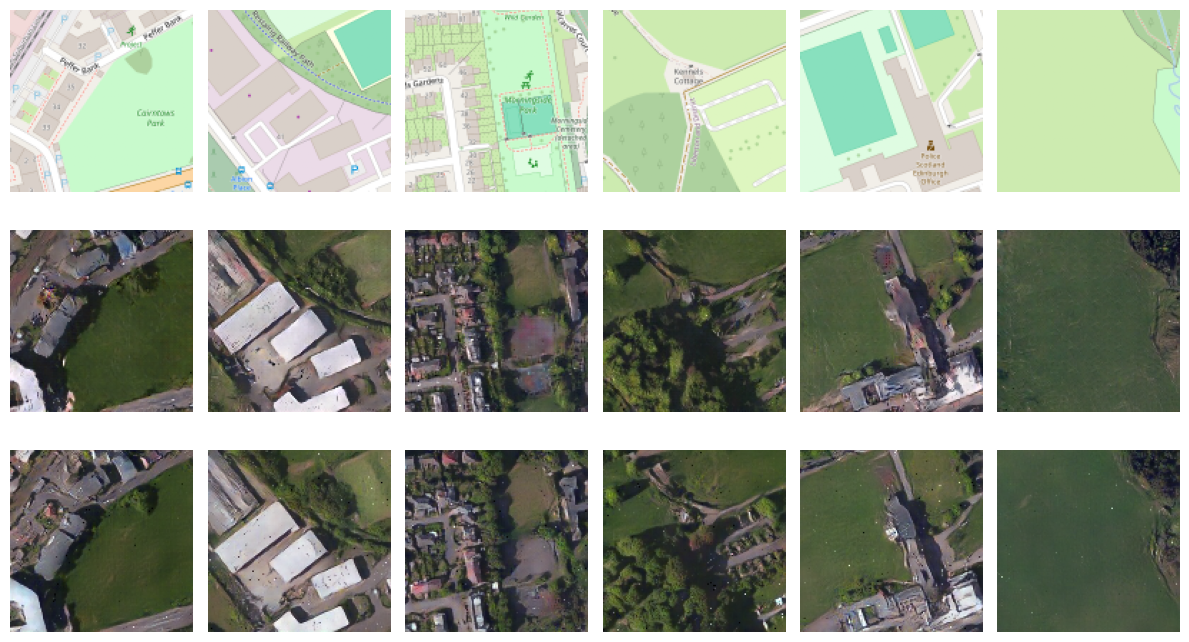

In [20]:
# Edinburgh: SingleGan Vs Gan+Refinement
showOff(BigGenEdi, divergenceNet, test_dataset_edi)

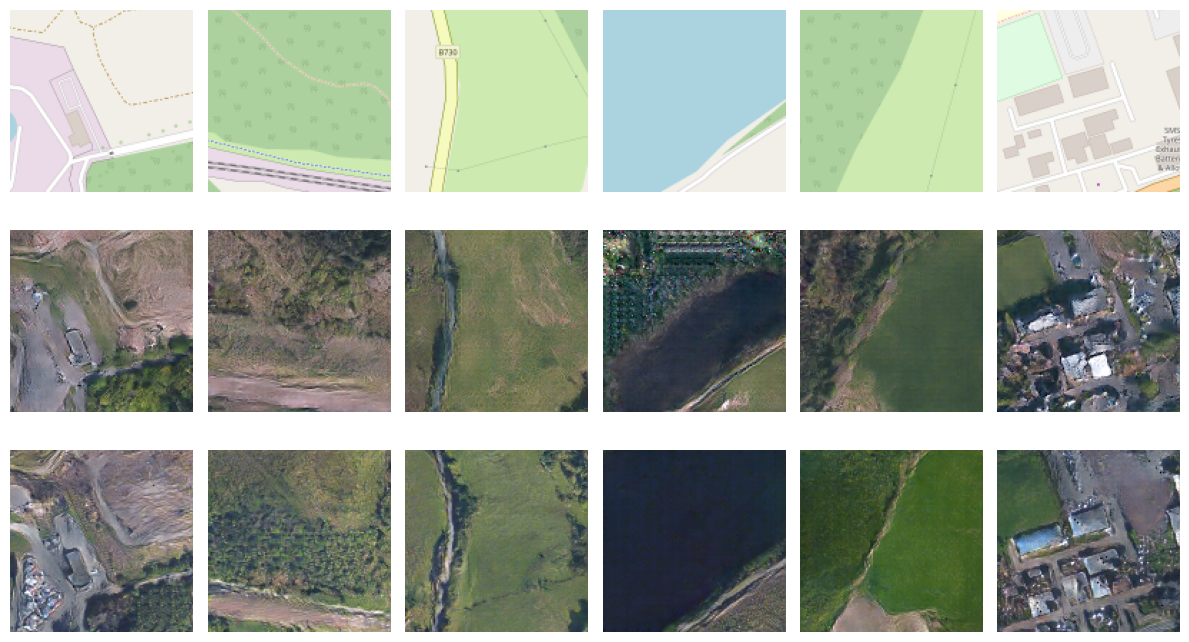

In [22]:
# Central Belt, Small Generator vs Big Generator
showOff(SmallGenCent, BigGenCent,  test_dataset_central)